# This is an implementation of a Convolutional Neural Network which will learn how to steer a car in the Udacity driving simulator

## What we have learning by completing this project is that the quality of the data is *the* most important part! We must aim to balance the classes in the dataset.
## Here I have balanced the data by ensuring roughly equal numbers of images from te left, center and right cameras - and also by dropping 50% of the zero steering angle data.
## A more thorough approach would to to break the data up into bins (for example with steering angles 0.01 wide) and then to ensure we have equal amounts of data in each bin.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, flip_axis, random_shift

from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, Lambda, Cropping2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split
from scipy.misc import imread, imresize, toimage
import cv2

# Visualizations will be shown inline
%matplotlib inline

Using TensorFlow backend.


### First lets have a look at the data

In [2]:
DATA_FILE = "session_data/driving_log.csv"

In [3]:
df = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3, 6])
df.describe(include="all")

,center,left,right,steering,speed
count,34703,34703,34703,34703.000000,34703.000000
unique,34703,34703,34703,NaN,NaN
top,session_data/IMG/center_2017_01_21_00_43_46_54...,session_data/IMG/left_2017_01_21_01_35_26_585...,session_data/IMG/right_2017_01_21_01_41_53_41...,NaN,NaN
freq,1,1,1,NaN,NaN
mean,NaN,NaN,NaN,-0.034182,29.980688
std,NaN,NaN,NaN,0.108575,2.199077
min,NaN,NaN,NaN,-0.893879,0.000078
25%,NaN,NaN,NaN,-0.039567,30.189370
50%,NaN,NaN,NaN,0.000000,30.190170
75%,NaN,NaN,NaN,0.000000,30.190300


#### Plot the data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1241f5d68>]], dtype=object)

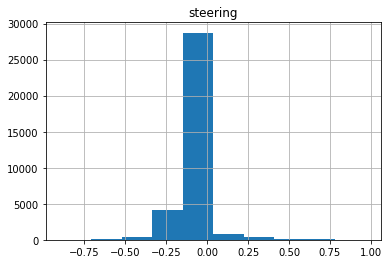

In [4]:
df.hist(column="steering")

#### What does the data distribution look like ignoring zero steering angles?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124663dd8>]], dtype=object)

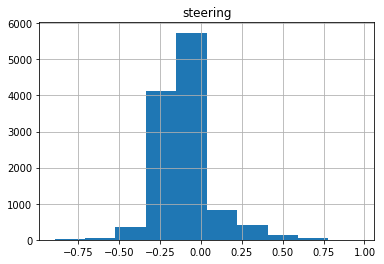

In [5]:
df_no_zeros = df[df.steering != 0]
df_no_zeros.hist(column="steering")

In [6]:
# Show a sample of the dataset
df.head(5)

,center,left,right,steering,speed
0,session_data/IMG/center_2017_01_21_00_16_39_18...,session_data/IMG/left_2017_01_21_00_16_39_183...,session_data/IMG/right_2017_01_21_00_16_39_18...,0.0,0.000078
1,session_data/IMG/center_2017_01_21_00_16_39_28...,session_data/IMG/left_2017_01_21_00_16_39_284...,session_data/IMG/right_2017_01_21_00_16_39_28...,0.0,0.000078
2,session_data/IMG/center_2017_01_21_00_16_39_38...,session_data/IMG/left_2017_01_21_00_16_39_386...,session_data/IMG/right_2017_01_21_00_16_39_38...,0.0,0.000082
3,session_data/IMG/center_2017_01_21_00_16_39_48...,session_data/IMG/left_2017_01_21_00_16_39_486...,session_data/IMG/right_2017_01_21_00_16_39_48...,0.0,0.000078
4,session_data/IMG/center_2017_01_21_00_16_39_58...,session_data/IMG/left_2017_01_21_00_16_39_587...,session_data/IMG/right_2017_01_21_00_16_39_58...,0.0,0.000078


#### As can be seen above the data set is highly unbalanced, with most of the data on (or close to) a zero steering angle.
#### The most important task we have is to try and balance this data set with augmentation...

## Print a random image from each camera

Shape:  (34703, 5)
Length:  34703
Random row:  27534
Image shape <PIL.Image.Image image mode=RGB size=320x160 at 0x116CBA0F0>


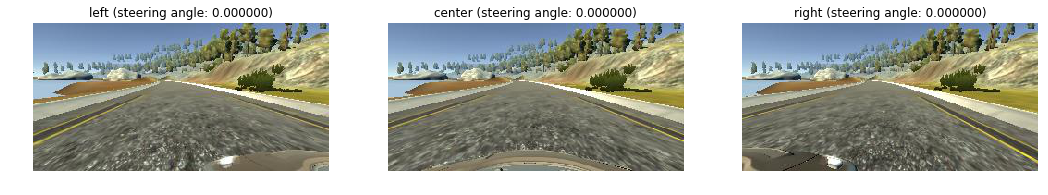

In [7]:
plt.rcParams["figure.figsize"] = (18, 10)

print("Shape: ", df.shape)
print("Length: ", len(df.index))

row = np.random.randint(len(df.index))
print("Random row: ", row)
print("Image shape {}".format(load_img(df.iloc[1]["center"].strip())))

i = 0
for camera in ["left", "center", "right"]:
    image = load_img(df.iloc[row][camera].strip())  #some columns have whitespace so strip it out
    image = img_to_array(image).astype("uint8")
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = "{} (steering angle: {:.6f})".format(camera, df.iloc[row]["steering"])
    plt.title(title)
    i += 1

## Pre-processing the data
We will randomly choose either the left, center or right camera image so that our data generator (below) provides a more balanced set of features to our model.

We have chosen a steering offset of +/- 0.25 to be applied to the left/right camera images respectively.<br>
We also randomly drop data with zero steering angle.

In [8]:
def read_log_file(random_drop_straight=False):
    """
    Read and process the log file that has already been opened above (in this notebook).
    A random selection is made to read either the left, center or right camera.
    
    random_drop_straight - If True will drop records with zero steering with 50% likelihood.
    Returns X, y dataset.
    """
    #from IPython.core.debugger import Tracer
    #Tracer()() #this one triggers the debugger
    
    steering_offset = 0.25
    X, y = [], []
    
    for center_img, left_img, right_img, steering_angle, speed in df.values:
        
        if random_drop_straight:
            if abs(float(steering_angle)) == 0.:
                if random.random() < 0.5:
                    continue
        
        # Randomly choose from either the left, center or right camera - this ensures an even
        # distribution of the data - this histogram above shows that otherwise we have way 
        # more straigth driving than turns...
        cam_view = np.random.choice(["center", "left", "right"])
        if cam_view == "left":
            X += [left_img.strip()]
            y += [float(steering_angle) + steering_offset]
        
        elif cam_view == "center":
            X += [center_img.strip()]
            y += [float(steering_angle)]
        
        elif cam_view == "right":
            X += [right_img.strip()]
            y += [float(steering_angle) - steering_offset]
    
    return X, y

In [9]:
def random_darken(image):
    """
    Given an image (from Image.open -> not a numpy array), randomly darken a part of it.
    
    image - PIL Image
    returns - PIL image with random dark rectangles.
    """
    w, h = image.size

    # Make a random box.
    x1, y1 = random.randint(0, w), random.randint(0, h)
    x2, y2 = random.randint(x1, w), random.randint(y1, h)

    # Loop through every pixel of our box (*GASP*) and darken.
    for i in range(x1, x2):
        for j in range(y1, y2):
            new_value = tuple([int(x * 0.5) for x in image.getpixel((i, j))])
            image.putpixel((i, j), new_value)
    return image

In [10]:
def augment_brightness(image):
    """
    Apply random brightness on the image
    
    image - Numpy image (shape row, columns, colours)
    returns - Numpy image with brightness adjusted.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:, :, 2] = image[:, :, 2] * random_bright
    
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    
    return image

In [11]:
def random_translation(image, steer, trans_range, trans_y=False):
    """
    Translate image and compensate for the translation on the steering angle
    
    image - Numpy image (shape: height, width, depth)
    steer - Steering angle (float)
    trans_range - The maximum range in pixles to randomly shift the image
    returns - tuple of numpy image and steering angle (float)
    """
    
    rows, cols, channels = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * .4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40 * np.random.uniform() - 40 / 2
    else:
        tr_y = 0
    
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, Trans_M, (cols, rows))
    
    return image_tr, steer_ang

In [12]:
# NOTE: Changes to the CROP size must be reflected in drive.py !!!
def crop_and_resize(image, y1, y2, x1, x2, shape=(100, 100, 3)):
    """
    Crop and Resize images to given shape.
    
    image - numpy image to crop
    y1 - top y coord for cropping
    y2 - bottom y coord for cropping
    x1 - left x coord for cropping
    x2 - right x coord for cropping
    shape - The shape to resize the image to
    returns - cropped and reshaped numpy image
    """
    #height, width, channels = shape
    #image_resized = np.empty([height, width, channels])
    
    cropped_image = image[y1:y2, x1:x2]
    image_resized = imresize(cropped_image, shape)

    return image_resized

In [13]:
def process_image(image_path, steering_angle, augment):
    """
    Given an image file path and associated steering angle, read in 
    the image and process it with the following augmentations:
     - random horizontal translation (with corresponding steering adjust)
     - horizontal image flipping with 50% likelihood
     - brightness augmentation
    returns - augmented numpy image and steering angle as tuple
    """
    image = load_img(image_path)
    
    #if augment and random.random() < 0.5:
    #    image = random_darken(image)  # before numpy'd
    
    image = img_to_array(image)
    
    if augment:
        #image = random_shift(image, 0, 0.2, 0, 1, 2)  # only vertical
        trans_range = 50
        image, steering_angle = random_translation(image, steering_angle, trans_range) # , trans_y=True
        
        if random.random() < 0.5:
            image = flip_axis(image, 1)
            steering_angle = -steering_angle
    
        image = augment_brightness(image)
        
    return image.astype(np.float32), steering_angle

In [14]:
def preprocess(image):
    """
    Image pre-processing.
    Performs a crop and resize then normalisation [-0.5, 0.5]
    This must be run on all images before the model sees them when training and testing.
    
    image - numpy image
    returns - preprocessed numpy image.
    """
    # image size
    im_y = image.shape[0]
    im_x = image.shape[1]
    trans_range = 50
    
    image = crop_and_resize(image, 20, 140, 0+trans_range, im_x-trans_range, shape=(66, 200, 3))
    image = (image / 255. - .5).astype(np.float32) #normalize
    return image

In [3]:
def generator(X, y, batch_size, augment=True):
    """
    Generator function which yields batch-size lots of features.
    Each batch is determined by selecting a random index into the data and 
    processing each data row, batc_size times.
    Processing entails, reading the actual image file and applying data
    augmentation and pre-processing.
    
    X - numpy images (features)
    y - numpy array of steering values (labels)
    batch_size - the size of the batches to return
    augment - we only want to augment data on the training run
    """
    while 1:
        batch_X, batch_y = [], []
        
        for i in range(batch_size):
            sample_index = random.randint(0, len(X) - 1)
            steering_angle = y[sample_index]
            
            image, steering_angle = process_image(X[sample_index], steering_angle, augment=augment)
            
            image = preprocess(image)
            
            batch_X.append(image)
            batch_y.append(steering_angle)
            
        yield np.array(batch_X), np.array(batch_y)

#### Lets run the generator function and print some images from the pipeline so we can see the augmentation

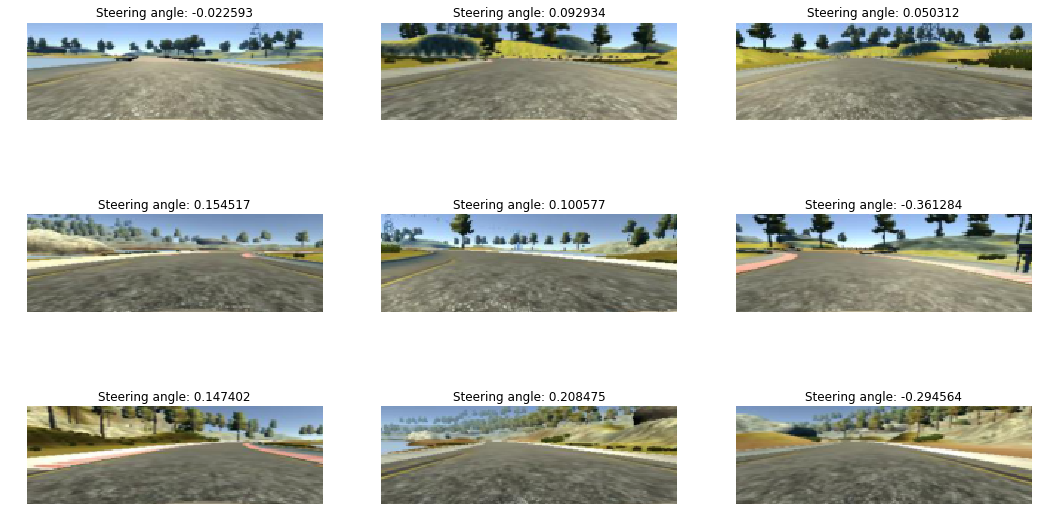

In [17]:
X, y = read_log_file(random_drop_straight=True)

plt.figure()
plt.rcParams["figure.figsize"] = (18, 10)

for pic in range(9):
    obj = generator(X, y, batch_size=1)
    next_batch = next(obj)
    
    image_from_array = next_batch[0][0]
    image_from_array = (image_from_array + .5) * 255 #undo the normalisation

    plt.subplot(3, 3, pic+1)
    plt.imshow(image_from_array.astype("uint8"))
    plt.axis('off')
    title = "Steering angle: {:.6f}".format(next_batch[1][0])
    plt.title(title)

## Build the ConvNet model

In [18]:
def model(load_model, shape):
    """
    Either load the model from a JSON file or create a deep convnet with guidance from the Nvidia
    lane following model.
    
    load_model - If True then load from a JSON file
    shape - (height, width, depth) of image being presented as the input layer to the model
    returns - the Keras model
    """
    if load_model:
        print("Loading model and pre-trained weights from save/model.json and save/model.h5")
        
        with open("save/model.json", "r") as jfile:
            model = model_from_json(jfile.read())

        model.compile("adam", "mse")
        model.load_weights("save.model.h5")
    else:
        # This is the same as the Nvidia model
        model = Sequential([
            Conv2D(24, 5, 5, input_shape=shape, subsample=(2, 2), W_regularizer=l2(0.01), activation="elu"),
            Dropout(0.2),
            
            Conv2D(36, 5, 5, subsample=(2, 2), activation="elu"),
            Dropout(0.2),
            
            Conv2D(48, 5, 5, subsample=(2, 2), activation="elu"),
            Dropout(0.2),
            
            Conv2D(64, 3, 3, subsample=(1, 1), activation="elu"),
            Dropout(0.2),
            
            Conv2D(64, 3, 3, subsample=(1, 1), activation="elu"),
            Dropout(0.2),
            
            Flatten(),
                
            Dense(100, activation="elu"),
            Dropout(0.2),
            
            Dense(50, activation="elu"),
            Dropout(0.2),
            
            Dense(10, activation="elu"),
            
            Dense(1, activation="linear")
        ])

        model.compile(optimizer=Adam(lr=0.0001), loss="mse")
        #model.summary()
    
    return model

## Train the model
Train the model over a maximum of 30 epochs (with early stopping) with batch size 128.<br>
We are using 10% of the training set as validation data - given the small amount of data I didn't want to use too much.<br>
At completion plot learning curves and save the model.<br>
The best weights are saved by a Keras callback function.

len X_train: 20965
len y_train: 20965
len X_val: 2330
len y_val: 2330
Epoch 1/30
40064/40064 [==============================] - 349s - loss: 0.1091 - val_loss: 0.0769

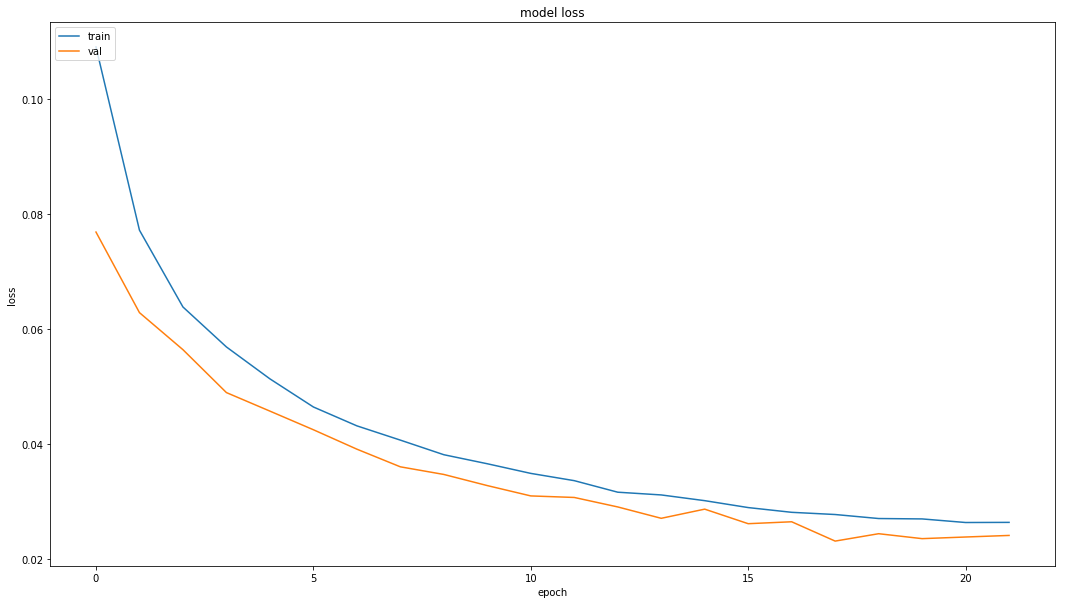



Training completed. Model saved to save/model.json and weights to save/model.h5


In [19]:
nb_epochs = 30
batch_size = 128


early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
save_weights = ModelCheckpoint("save/model.h5", monitor="val_loss", save_best_only=True, save_weights_only=True)

net = model(load_model=False, shape=(66, 200, 3))

X, y = read_log_file(random_drop_straight=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10)

print("len X_train:", len(X_train))
print("len y_train:", len(y_train))
print("len X_val:", len(X_val))
print("len y_val:", len(y_val))


history = net.fit_generator(
    generator(X_train, y_train, batch_size),
    samples_per_epoch=128*313,
    nb_epoch=nb_epochs,
    callbacks=[early_stopping, save_weights],
    validation_data=generator(X_val, y_val, batch_size, augment=False),
    nb_val_samples=len(X_val))

# Summarise history for loss
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

##
# Save model - note that the best weights are already saved above with the save_weights callback
##

json = net.to_json()
#model.save_weights("save/model.h5")
with open("save/model.json", "w") as f:
    f.write(json)

print("\n\nTraining completed. Model saved to save/model.json and weights to save/model.h5")

### This model drives very nicely non-stop all the way around both the training track and the more difficult test track!

Note however that if you run the simulator in high resolution mode, lots more shadows are generated over track 2 which are quite dark and our model cannot generalise to them.<br>
We are not using the random shadow augmentation above as I was finding that too often it just draws a small dark patch on the screen instead of a broad shadow.<br>
With some rework of this shadow generation logic I'm sure the model will then be able to handle the test track in the higher resolution mode.<br><br>

To-Do's
1. Test with BatchNorm (probably remove the dropout layers after the conv layers with this)
2. Apply ZCA Whitening from Keras library -- or -- Histogram equalization:
     -- # Apply localized histogram localization
        for i in range(X.shape[0]):
            X[i] = exposure.equalize_adapthist(X[i])
3. Switch to SGD with momentum, etc. e.g. SGD(lr=0.01, decay=1e-6, momentum=0.1, nesterov=True)
4. Try fine-tuning an Imagenet based model